# Tutorial on how to fit emission line and crate emission line maps for JWST/NIRSPEC IFS

## Fitting Halpha of already extracted spectrum - the basics

We will first focus on fitting a Halpha spectrum of an objects called cdfs 38 from KASHz survey. It is an type-2 AGN but without any signs of outflow or by definition, broad line region. I have already extracted the spectrum from the KMOS cube. Once we learn how to fit a spectrum, we can fit a cube next. 

Lets start with importing basic libraries. This is a start of every code I write. 

In [1]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt; plt.ioff()

from astropy.io import fits as pyfits
from astropy import wcs
from astropy.table import Table, join, vstack
from matplotlib.backends.backend_pdf import PdfPages
import pickle

import Graph_setup as gst 

nan= float('nan')

pi= np.pi
e= np.e

plt.close('all')
c= 3.*10**8
h= 6.62*10**-34
k= 1.38*10**-23

Ken98= (4.5*10**-44)
Conversion2Chabrier=1.7 # Also Madau
Calzetti12= 2.8*10**-44
arrow = u'$\u2193$' 

%load_ext autoreload
%autoreload 2

PATH= '/Users/jansen/My Drive/Astro/' # My general path for stuff
fsz = gst.graph_format()

import IFU_tools_class as IFU
import Plotting_tools_v2 as emplot
import Fitting_tools_mcmc as emfit

# Add comments

Set DATE-AVG to '2022-08-26T21:06:16.023' from MJD-AVG.
Set DATE-END to '2022-08-26T23:18:28.809' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.606940 from OBSGEO-[XYZ].
Set OBSGEO-H to 1537709966.572 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Masking edges based on 0.1 scale
location of the peak on the continuum (array([28]), array([26]))
Initial guesses (0.019407775, 26, 28, 1, 1, 0, 0)
Cont loc  [26.01966963 28.01106057]
Cont loc er [0.07401615 0.06878551]
Center of cont [26.01966963 28.01106057]
Extracting spectrum from diameter 0.3 arcseconds
Pixel scale: 10.0
radius  1.5
[0.0588394 0.0588394 0.0588394 ... 0.0588394 0.0588394 0.0588394]


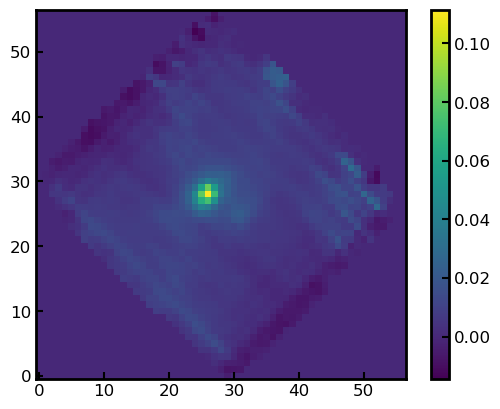

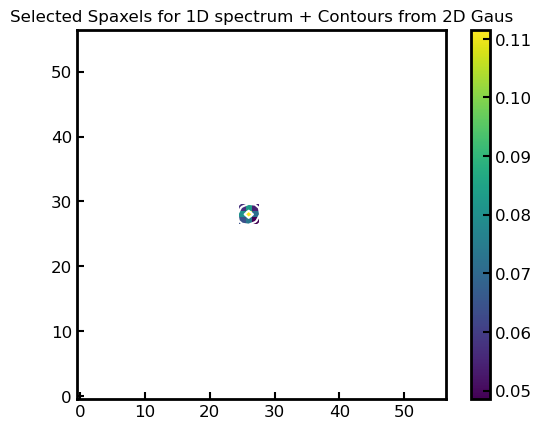

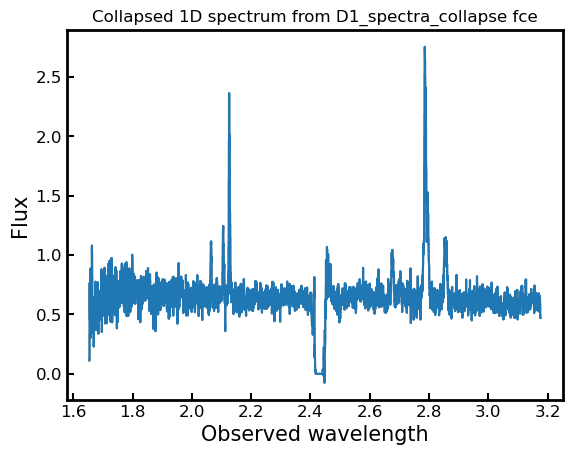

In [2]:
Cube_path = PATH+'JWST/Data/GTO/GA20936/20936-GS-3.25-S_jw1216_o003_woff_px0.1_emsm_wODfde95 _wCR4_wVBC_wSJC_wSPC_wCTX1000.pmap_g235h-f170lp_extfluxcal_s3d.fits'
z_initial = 3.2477
ID = 'GS-20936'
Instrument_flag = 'NIRSPEC_IFU_fl'
Save_path = PATH+'JWST/Data/GTO/'
band = 'NIRSPEC'
normalization = 1e-16
plot_it = 1
Cube = IFU.Cube( Cube_path, z_initial, ID, Instrument_flag, Save_path , band, norm=normalization)

Cube.mask_JWST(plot_it, threshold=3e-21*1000/1e-16)#, spe_ma=[1295,1296,1070,1071,2357,2358,2359,2360])
Cube.collapse_white(plot_it)

Cube.find_center(plot_it) #  manual=[26,28]
Cube.choose_pixels(plot_it, rad= 0.15)
Cube.D1_spectra_collapse(plot_it, addsave='', err_range=[2.17,2.26,2.6,2.76], boundary=2.4)
plt.show()




# Fitting Halpha emission line complex
Lets start with Halpha

Options for the AGN are:
AGN = 'BLR' fits type 1 and type 2 options and picks the best - chooses the best based on BIC 

    = 'Outflow' - fits type 2 and type 2 with an outflow in Halpha and [NII] - chooses the best based on BIC
    
    = 'Single_only', 'BLR_only', 'Outflow_only' - fits only one of the models - saves time 
    
    = 'QSO_BKPL' - it fits brokenpowerlaw QSO model. 

  1%|▍                                     | 113/10000 [00:00<00:26, 369.90it/s]/Users/jansen/My Drive/MyPython/Qubespec/Halpha_models.py:227: RuntimeWarning: invalid value encountered in log10
  and priors['Hal_out_peak'][1] < np.log10(Hal_out_peak) < priors['Hal_out_peak'][2] and priors['outflow_fwhm'][1] < outflow_fwhm <priors['outflow_fwhm'][2] \
/Users/jansen/My Drive/MyPython/Qubespec/Halpha_models.py:228: RuntimeWarning: invalid value encountered in log10
  and priors['NII_out_peak'][1] < np.log10(NII_out_peak) < priors['NII_out_peak'][2] and priors['outflow_vel'][1] < outflow_vel <priors['outflow_vel'][2]\
100%|████████████████████████████████████| 10000/10000 [00:20<00:00, 488.06it/s]


Delta BIC -154.77188775159493  
BICM 797.6198415141575


SNR hal  115.1192262291503
SNR SII  37.06686507654173


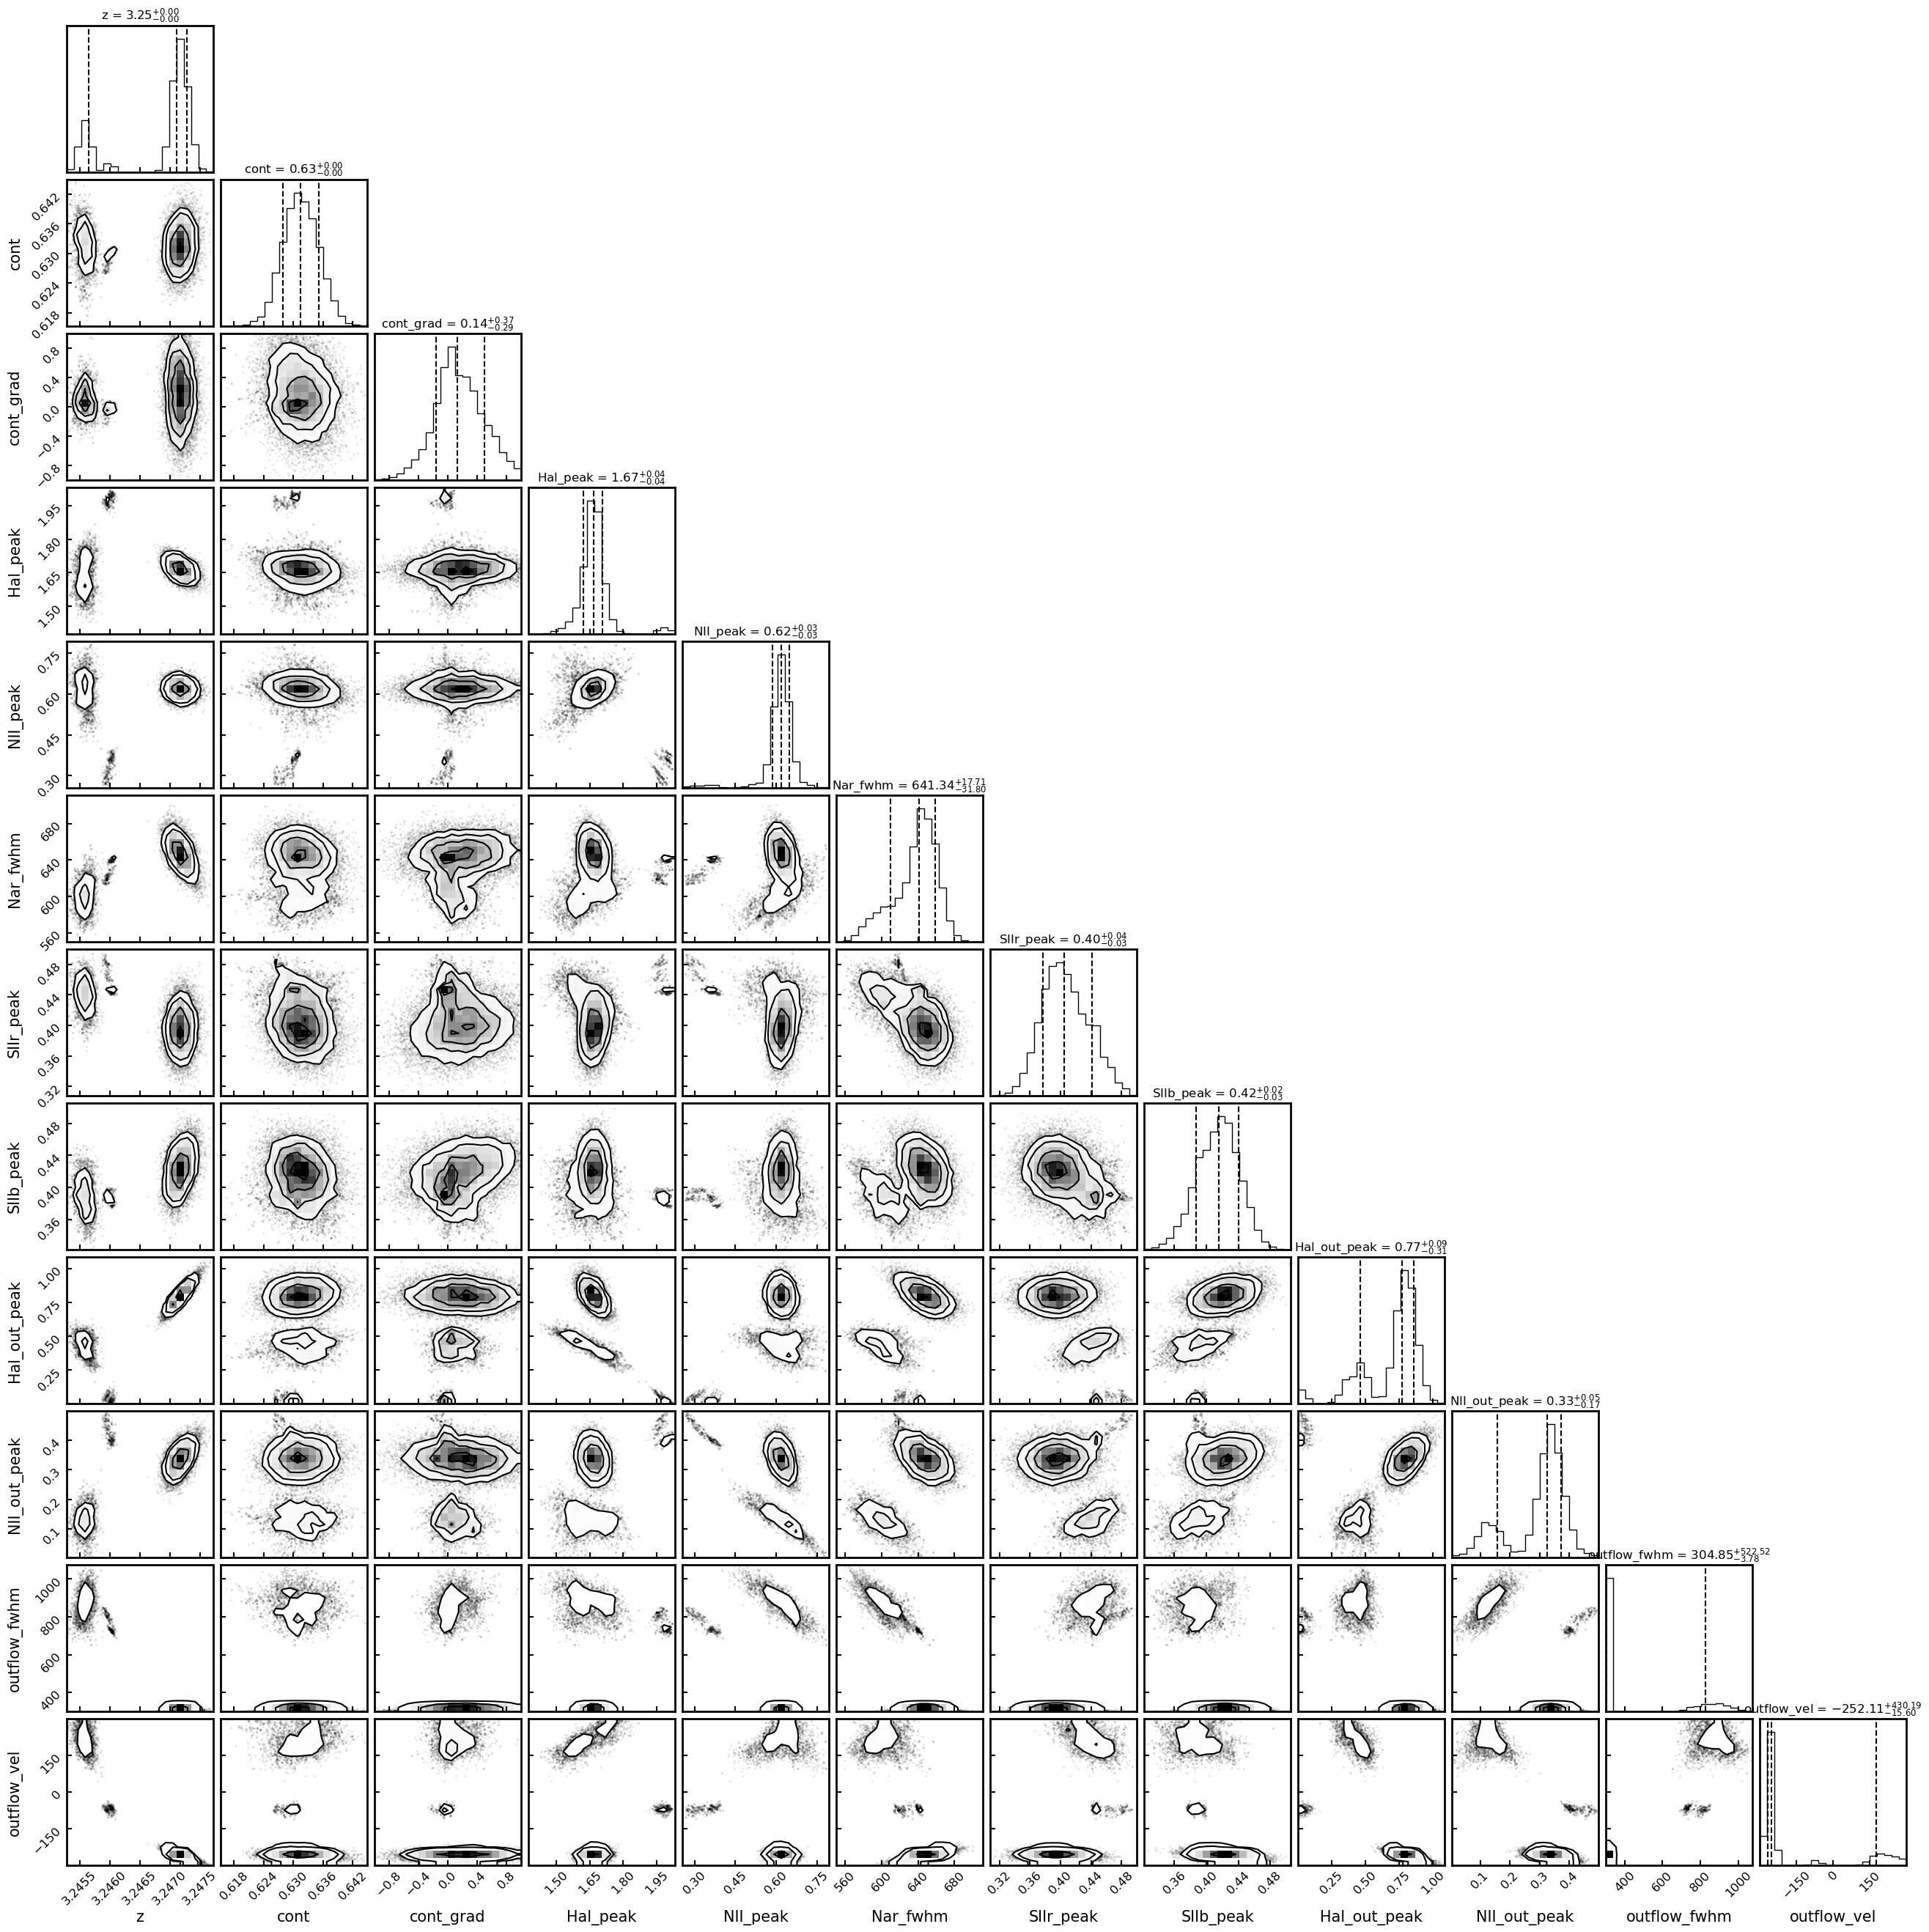

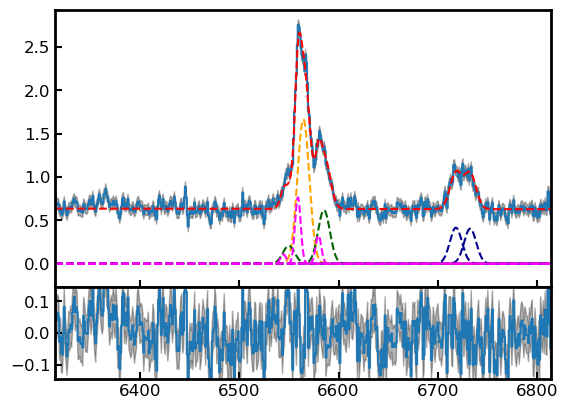

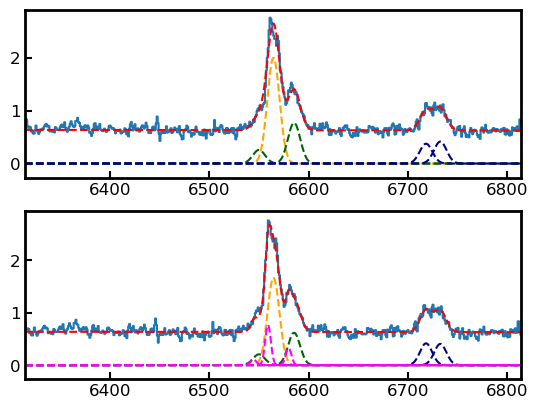

In [3]:
priors= {'cont':[0,-3,1],\
         'cont_grad':[0,-1,1], \
         'Hal_peak':[0,-3,1],\
         'BLR_peak':[0,-3,1],\
         'NII_peak':[0,-3,1],\
         'Nar_fwhm':[300,100,900],\
         'BLR_fwhm':[4000,2000,9000],\
         'BLR_offset':[-200,-900,600],\
         'SII_rpk':[0,-3,1],\
         'SII_bpk':[0,-3,1],\
         'Hal_out_peak':[0,-3,1],\
         'NII_out_peak':[0,-3,1],\
         'outflow_fwhm':[600,300,1500],\
         'outflow_vel':[-50, -300,300]}

Cube.fitting_collapse_Halpha(plot_it, AGN='Outflow', priors=priors,N=10000)
plt.show()

# Fitting [OIII] + Hbeta complex only

outflow = 'both' fits [OIII] with and without a broad component and picks the best based on BIC


        = 'single' - fits a single gaussian to [OIII]
        
        = 'outflow' - fits 2 gaussians only to [OIII]
        
        = 'QSO'/'QSO_BKP' - it fits 

Hbeta_dual - 0/1 fits one or two gaussians to the Hbeta - ideal for AGN with visible BLR region. 

template = 0 no FeII template

        = 'Veron', 'BG92', 'Tsuzuki' - fits one of these FeII templates

100%|██████████████████████████████████████| 6000/6000 [00:19<00:00, 315.32it/s]


Delta BIC -142.00766951176348  
['name', 'z', 'cont', 'cont_grad', 'OIIIn_peak', 'OIIIw_peak', 'OIIIn_fwhm', 'OIIIw_fwhm', 'out_vel', 'Hbeta_peak', 'Hbeta_fwhm', 'Hbeta_vel', 'popt']


58.23447083812529
16.631193509035274


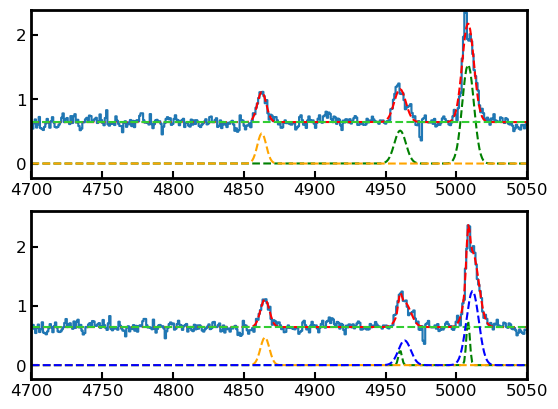

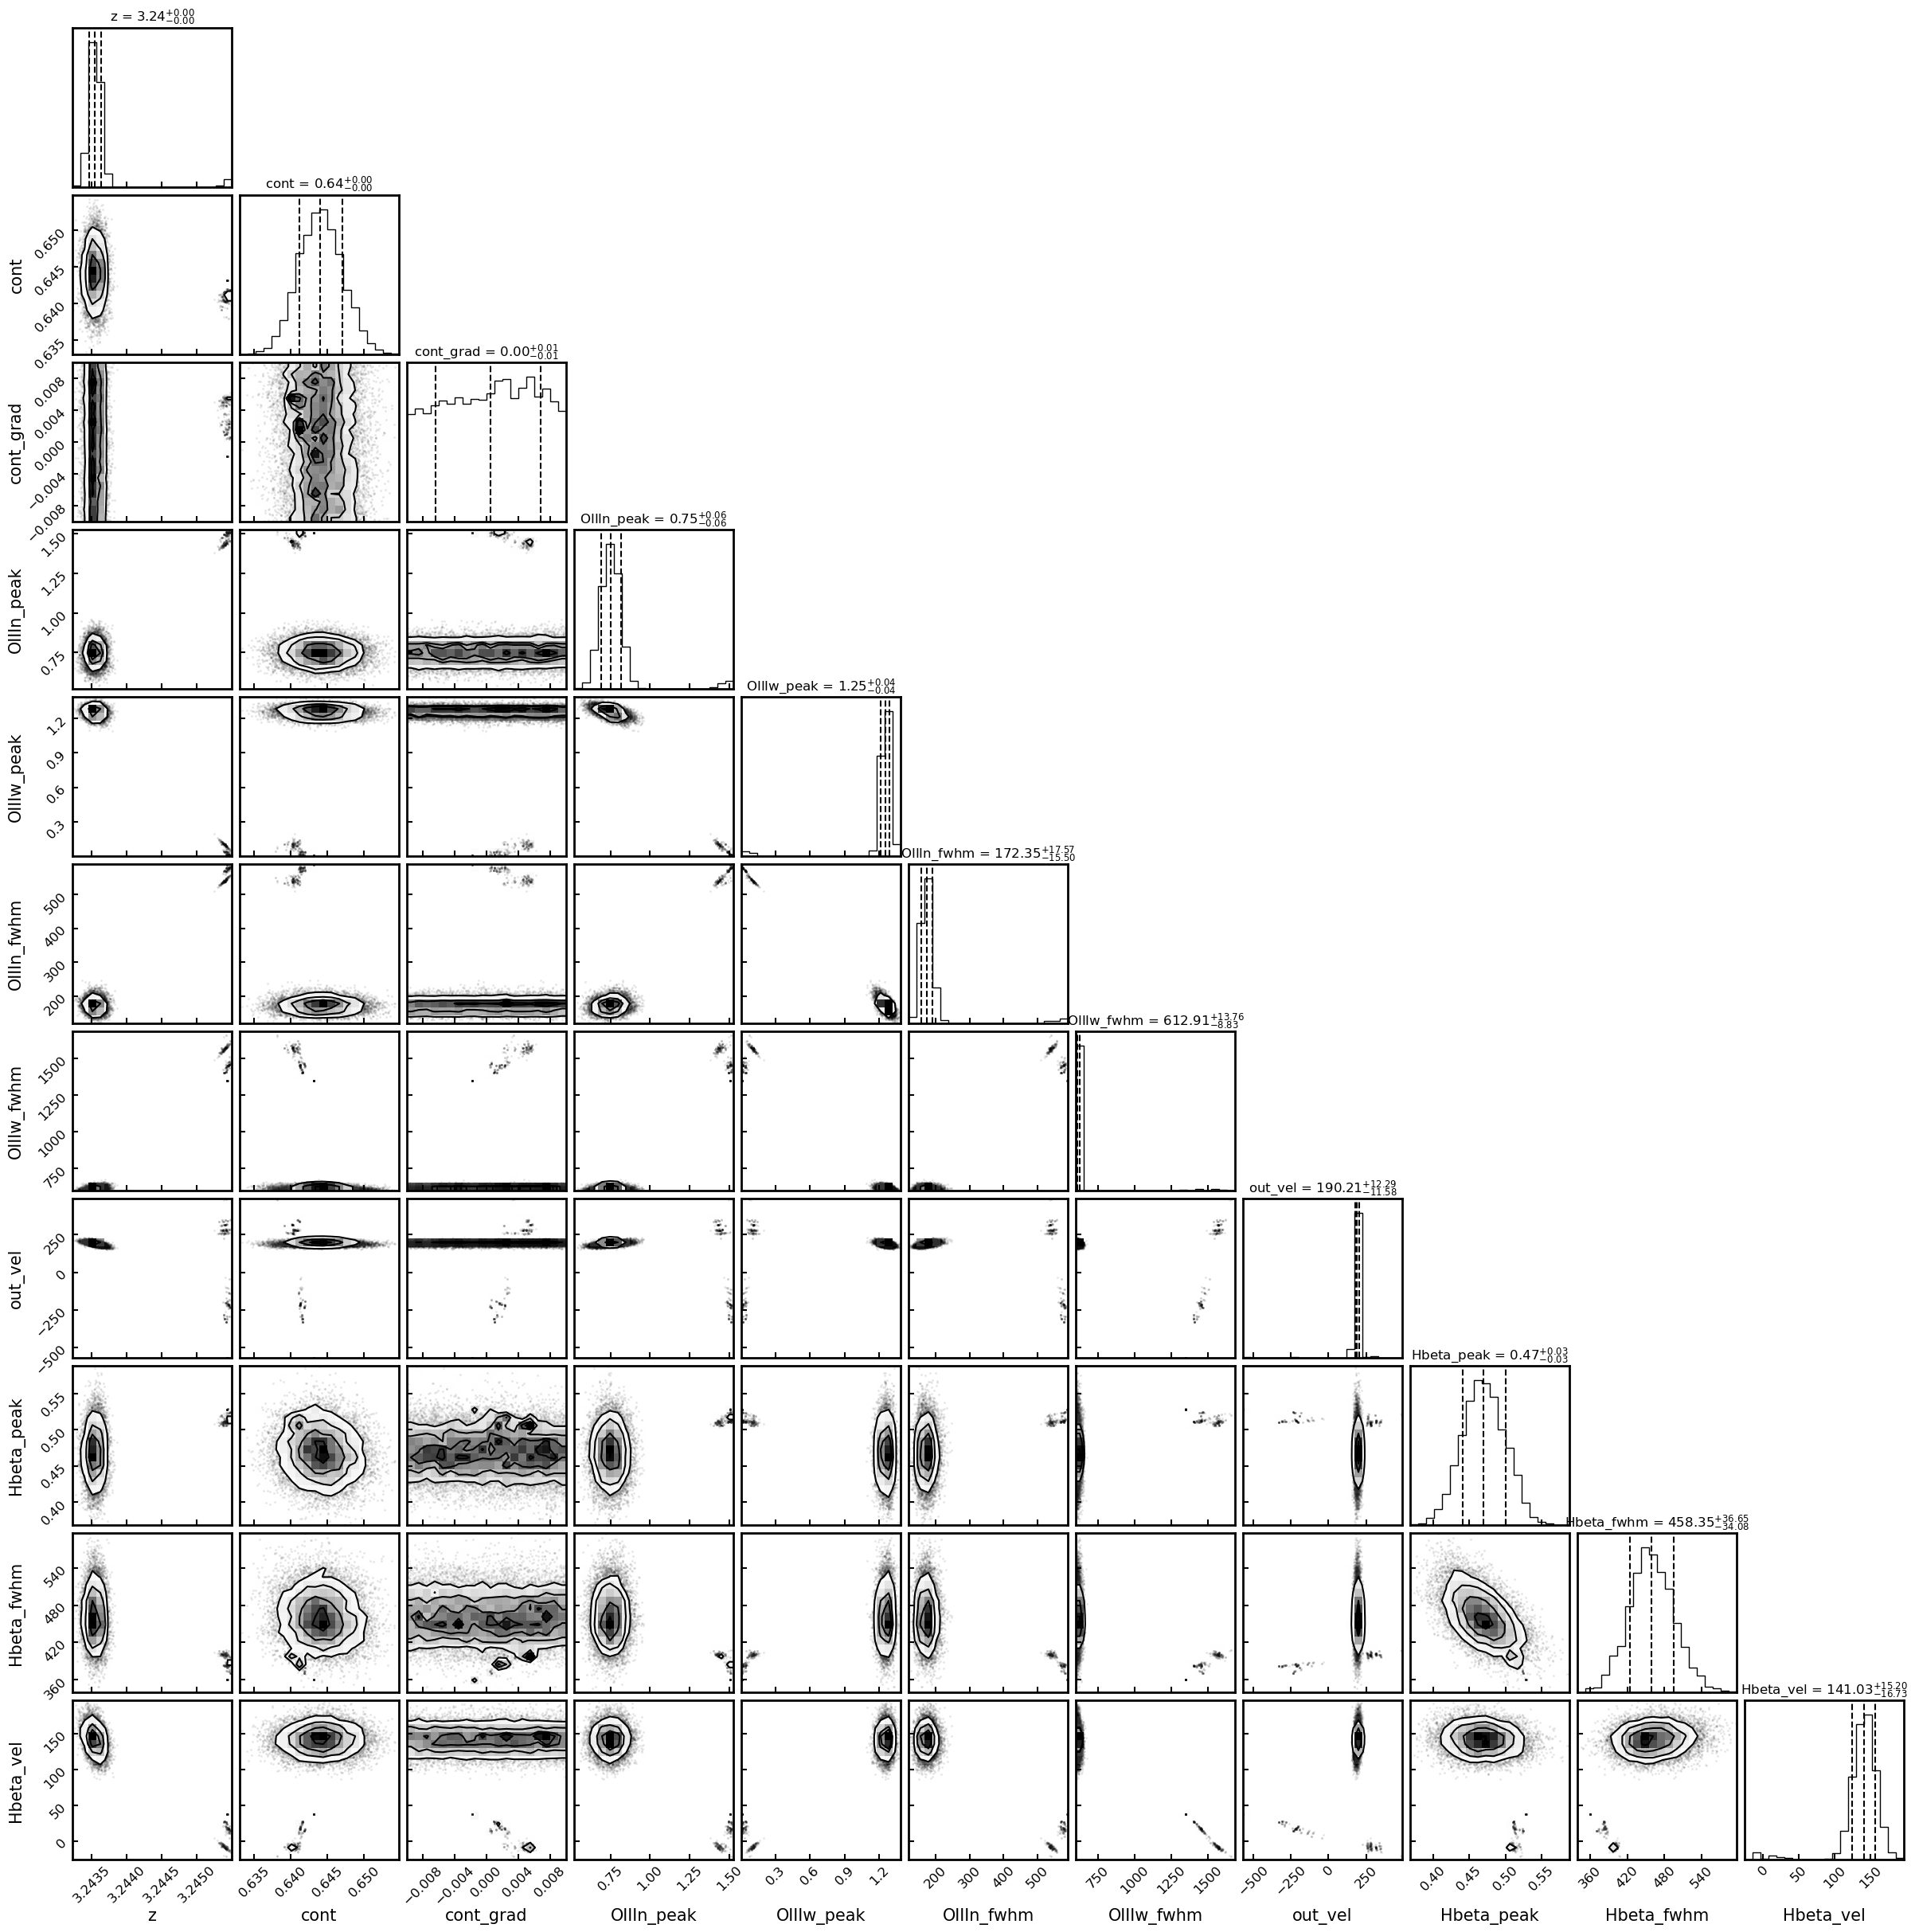

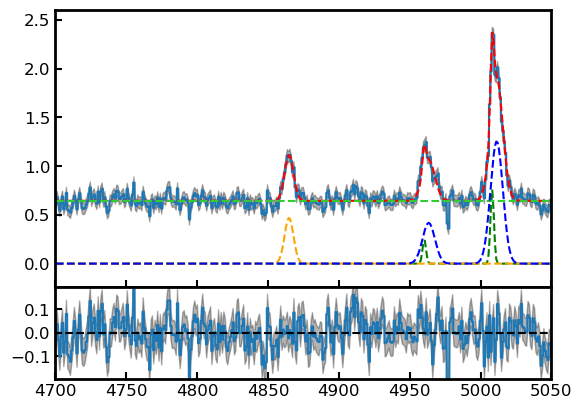

In [5]:
priors= {'cont':[0,-3,1],\
         'cont_grad':[0,-1,1], \
         'OIIIn_peak':[0,-3,1],\
         'OIIIw_peak':[0,-3,1],\
         'OIII_fwhm':[300,100,900],\
         'OIII_out':[900,600,2500],\
         'out_vel':[-200,-900,600],\
         'Hbeta_peak':[0,-3,1],\
         'Hbeta_fwhm':[200,120,7000],\
         'Hbeta_vel':[10,-200,200],\
         'Hbetan_peak':[0,-3,1],\
         'Hbetan_fwhm':[300,120,700],\
         'Hbetan_vel':[10,-100,100],\
         'Fe_peak':[0,-3,2],\
         'Fe_fwhm':[3000,2000,6000]}


Cube.fitting_collapse_OIII(plot_it, outflow='both', Hbeta_dual=0, N=6000)
plt.show()

# Fitting all emission lines at once

Currently implemented only one model - simpliest without any outflow/BLR components 

- Discussion question: The [OIII] and Halpha kinematics are disconnected - Coming from AGN. Do people agree? Do we link Halpha/[OIII] outflow together?

  0%|                                                  | 0/6000 [00:00<?, ?it/s]/Users/jansen/opt/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▎                                        | 49/6000 [00:00<01:18, 76.27it/s]/Users/jansen/My Drive/MyPython/Qubespec/Halpha_OIII_models.py:200: RuntimeWarning: invalid value encountered in log10
  and priors['OI_peak'][1] < np.log10(OI_peak) < priors['OI_peak'][2]\
  1%|▍                                        | 57/6000 [00:00<01:19, 75.22it/s]/Users/jansen/My Drive/MyPython/Qubespec/Halpha_OIII_models.py:199: RuntimeWarning: invalid value encountered in log10
  and priors['SII_rpk'][1] < np.log10(SII_rpk) < priors['SII_rpk'][2] and priors['SII_bpk'][1] < np.log10(SII_bpk)<priors['SII_bpk'][2]\
  1%|▍                                        | 73/6000 [00:00<01:22, 72.25it/s]/Users/jansen/My Drive/MyPython/Qubespec/Halpha_OI

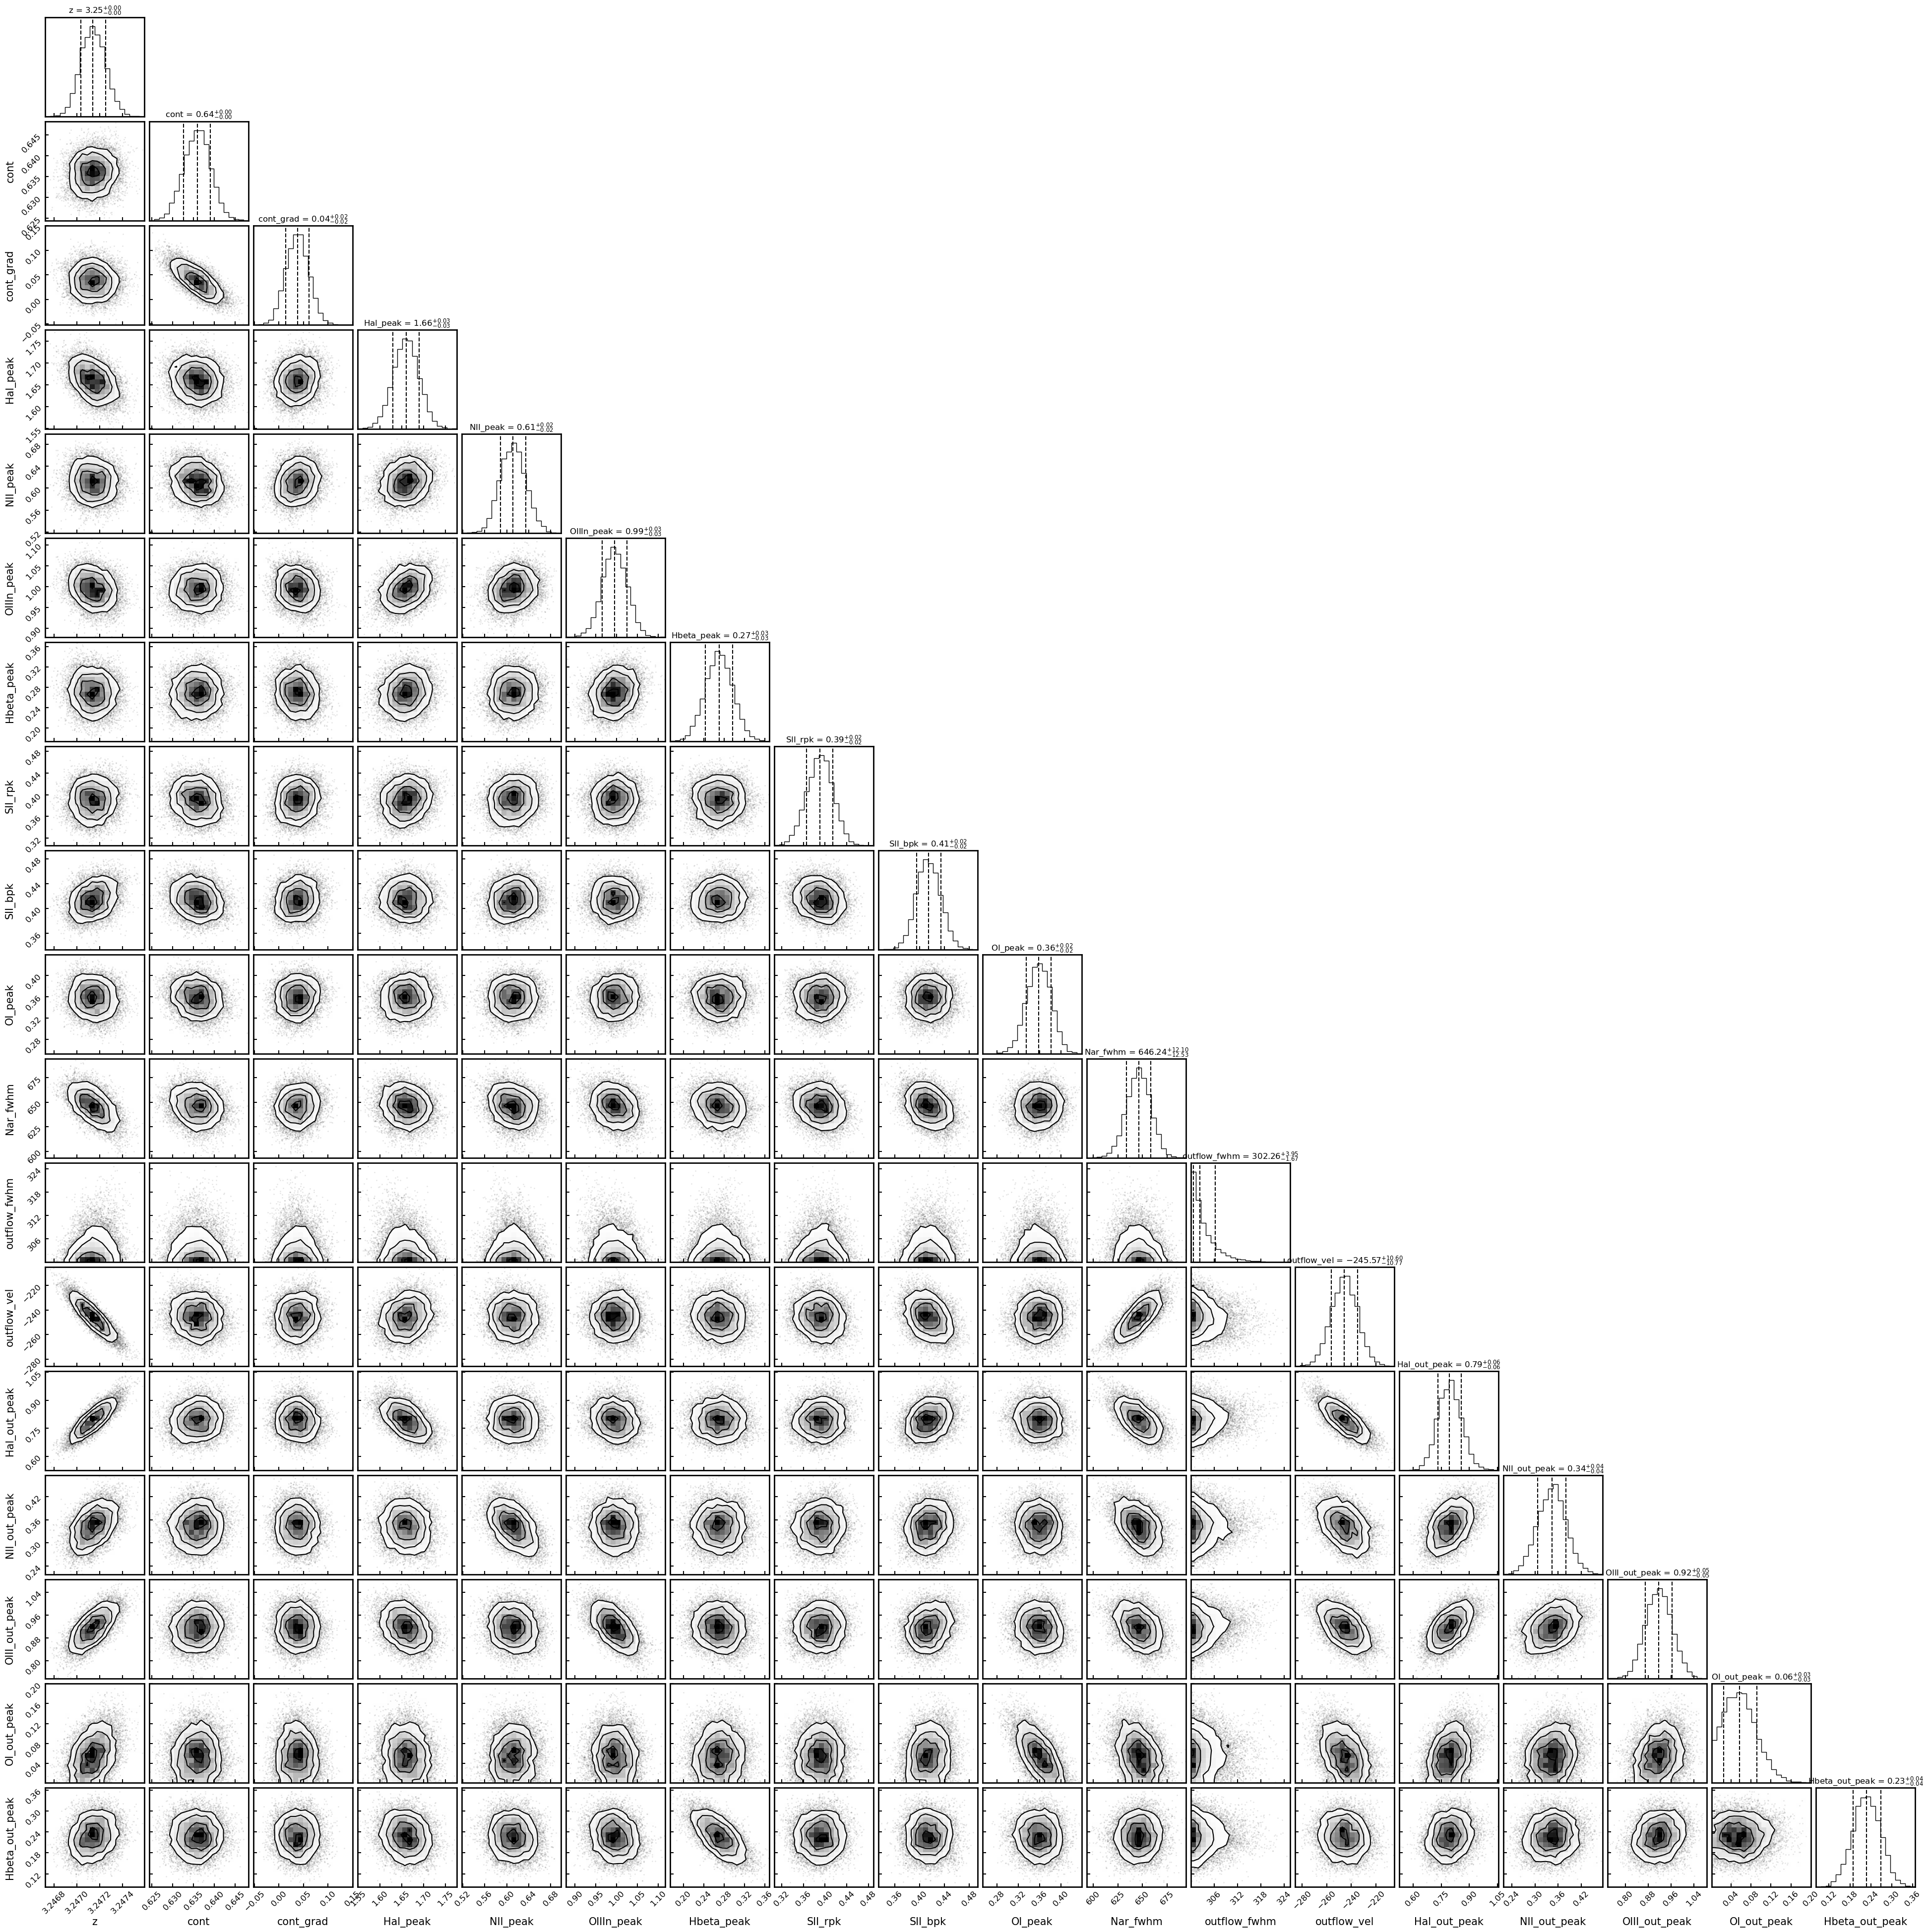

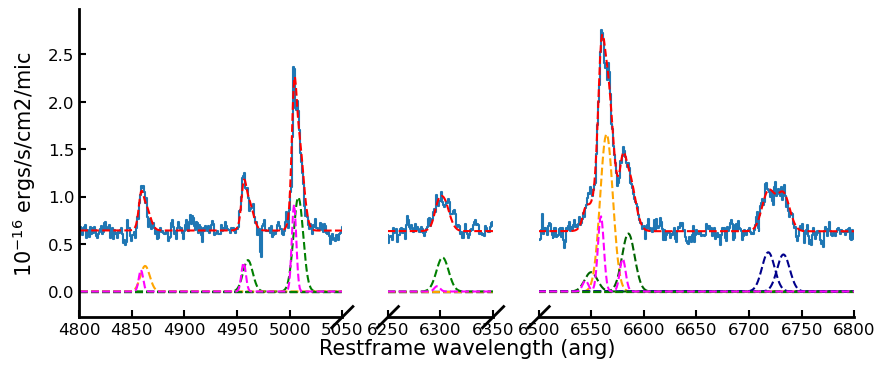

In [18]:
priors= {'cont':[0,-3,1],\
         'cont_grad':[0,-10.,10], \
         'OIIIn_peak':[0,-3,1],\
         'OIIIn_fwhm':[300,100,900],\
         'OIII_vel':[-100,-600,600],\
         'Hbeta_peak':[0,-3,1],\
         'Hal_peak':[0,-3,1],\
         'Nar_fwhm':[300,150,900],\
         'SII_rpk':[0,-3,1],\
         'SII_bpk':[0,-3,1],\
         'OI_peak':[0,-3,1]}

Cube.fitting_collapse_Halpha_OIII(plot_it,N=6000, outflow='Outflow_only')

plt.show()

Put some comments here!

In [17]:
print(Cube.D1_fit_results)
print('Flux Halpha ', IFU.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'Han', Cube.flux_norm))
print('Flux NII ', IFU.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'NII', Cube.flux_norm))
print('Flux OIII ', IFU.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'OIIIt', Cube.flux_norm))
print('Flux nar hbeta', IFU.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'Hbeta', Cube.flux_norm))
print('Flux OI', IFU.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'OI', Cube.flux_norm))
print('Flux SIIr', IFU.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'SIIr', Cube.flux_norm))
print('Flux SIIb', IFU.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'SIIb', Cube.flux_norm))


{'name': 'Halpha_OIII_outflow', 'z': array([3.24674342e+00, 6.84711796e-04, 2.86791954e-04]), 'cont': array([0.63759444, 0.00555987, 0.00391204]), 'cont_grad': array([0.03630268, 0.02474894, 0.02928203]), 'Hal_peak': array([1.64044292, 0.0613257 , 0.0847358 ]), 'NII_peak': array([0.47471699, 0.1719185 , 0.13108074]), 'OIIIn_peak': array([0.93758715, 0.12450819, 0.20080672]), 'Hbeta_peak': array([0.33442763, 0.04946535, 0.0780838 ]), 'SII_rpk': array([0.39325998, 0.032768  , 0.03960913]), 'SII_bpk': array([0.39553607, 0.02787047, 0.02686475]), 'OI_peak': array([0.26746184, 0.13972414, 0.09251768]), 'Nar_fwhm': array([657.38156116,  74.94540107,  17.09538431]), 'outflow_fwhm': array([329.97999139,  26.28832083, 486.93028583]), 'outflow_vel': array([-192.6121602 ,   41.3565052 ,   50.00552042]), 'Hal_out_peak': array([0.60098461, 0.27121828, 0.11961554]), 'NII_out_peak': array([0.44125467, 0.09523037, 0.0717123 ]), 'OIII_out_peak': array([0.83596886, 0.45091457, 0.06181613]), 'OI_out_peak

[57, 57, 3844]


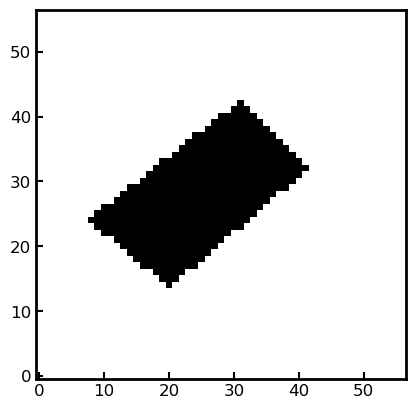

In [8]:
import cv2

dims = Cube.dim
print(dims)
x = np.ones((dims[0], dims[1]), dtype=np.uint8)
pts = np.array([[8,24],
[20,14],
[41,32],
[31,42]], np.int32).reshape(-1, 1, 2)

mask = cv2.fillPoly(x,[pts],0)
plt.imshow(mask, cmap='gray', origin='lower')

plt.show()

In [9]:
Unwrapping = False
if Unwrapping==True:
    
    Cube.unwrap_cube(rad=0.3, instrument='NIRSPEC',mask_manual=mask, err_range=[2.17,2.26,2.6,2.76], boundary=2.4) 
    

In [ ]:
'''
priors= {'cont':[0,-3,1],\
         'cont_grad':[0,-0.01,0.01], \
         'OIIIn_peak':[0,-3,1],\
         'Hbeta_peak':[0,-3,1],\ 
         'Hal_peak':[0,-3,1],\
         'NII_peak':[0,-3,1],\
         'Nar_fwhm':[300,150,900],\
         'SII_rpk':[0,-3,1],\
         'SII_bpk':[0,-3,1],\
         'OI_peak':[0,-3,1]}
'''
Spaxel = False
if Spaxel==True: 
    if __name__ == '__main__':
        Cube.Spaxel_fitting_Halpha_OIII_MCMC_mp()


Next we will prep the data for fitting:
1) will only include channels (data) that was not masked. 

2)  We are not really interested in fitting the whole spectral window. We are only interested in the range our the spectral line. I like to go +- 300 angstroms around the line.

3) Lastly, we need to find the value of the peak of the line - we will use this when creating initial conditions. 

In [10]:
Map_pp = False
 
if Map_pp==True:
    fmaps = Cube.Map_creation_Halpha_OIII(flux_max=1e-19, SNR_cut=3., fwhmrange=[200,700], velrange=[-200,200])
    plt.show()

ok so now is the time to do the actual fitting and deal with the results:

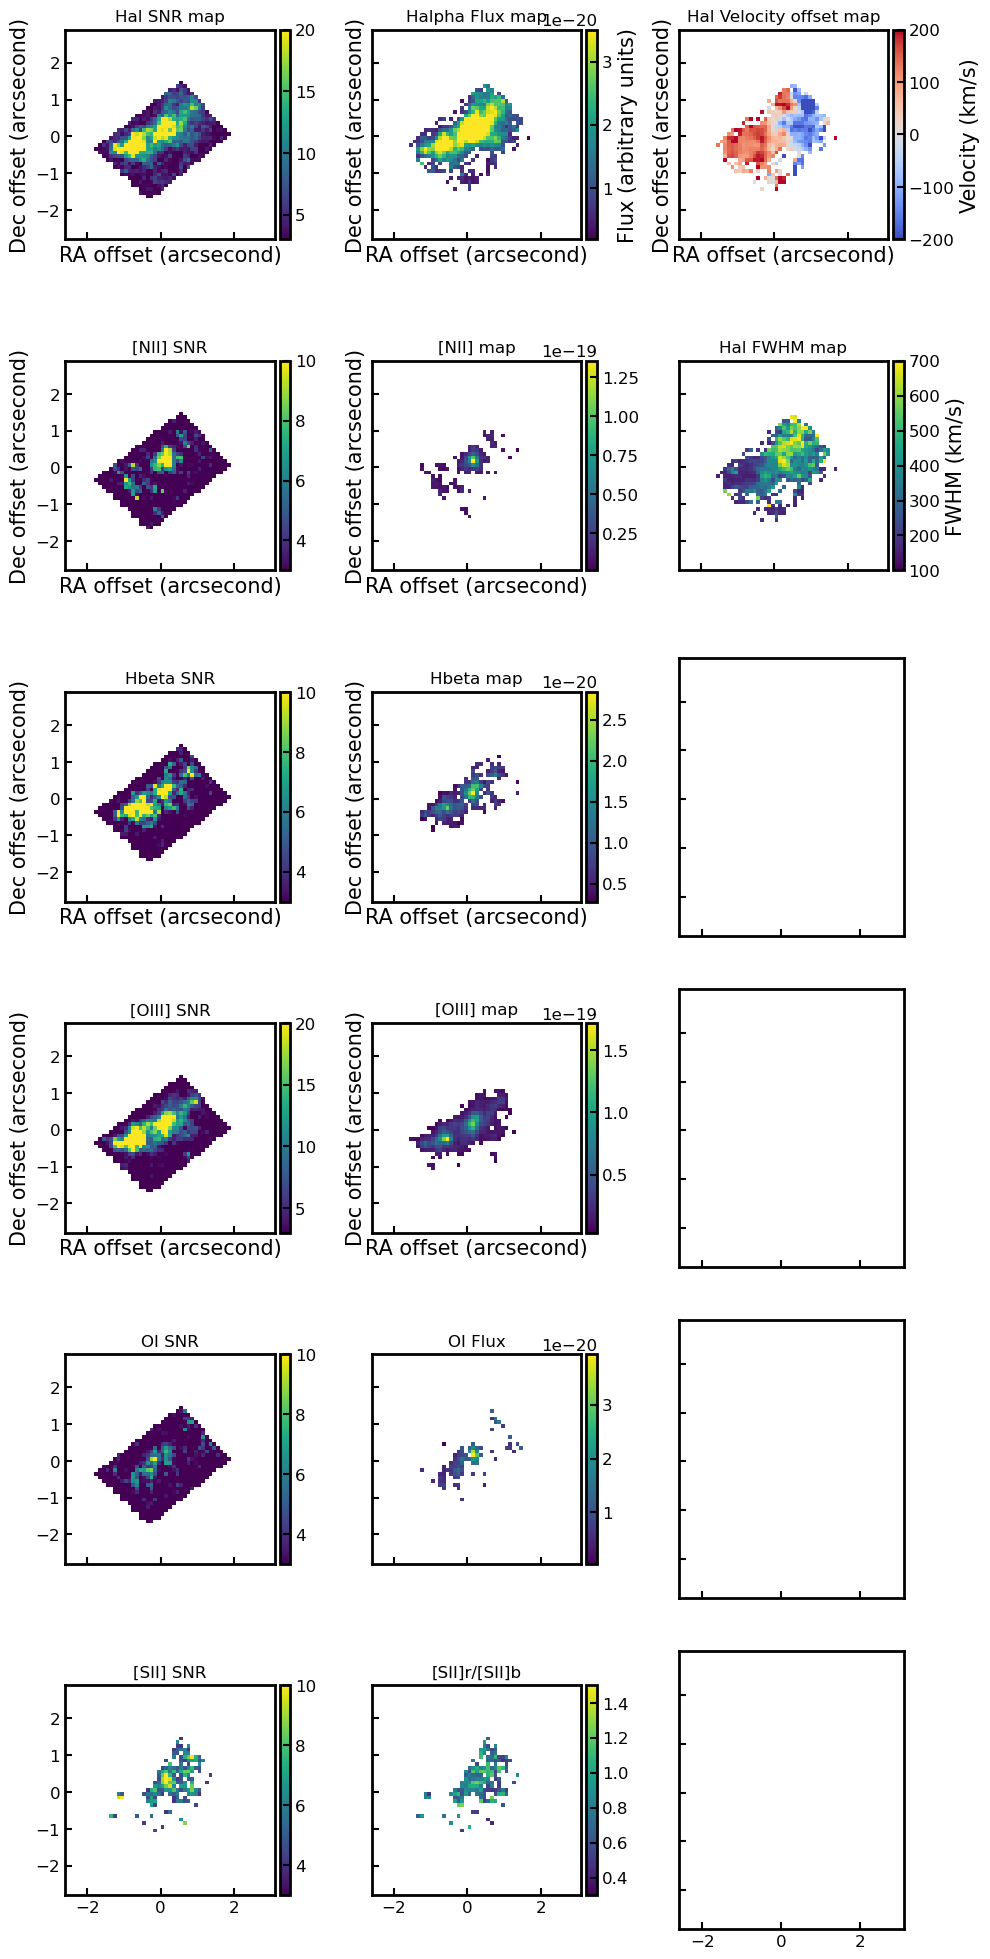

In [19]:

emplot.Plot_results_Halpha_OIII('/Users/jansen/My Drive/Astro/JWST/Data/GTO/GS-20936_Halpha_OIII_fits_maps.fits', center=[26,28],\
                               fwhmrange = [100,700], velrange=[-200,200], flux_max=0)
#fmaps.savefig(PATH+'JWST/Graphs_GS-20936/Hal_OIII_maps_full.pdf')

plt.show()

Lets quickly check the corner plot for these chains

Center of cont [19, 24]
Extracting spectrum from diameter 0.6 arcseconds
Pixel scale: 10.0
radius  3.0


  0%|                                                  | 0/6000 [00:00<?, ?it/s]/Users/jansen/My Drive/MyPython/Qubespec/Halpha_OIII_models.py:108: RuntimeWarning: invalid value encountered in log10
  if priors['z'][1] < z < priors['z'][2] and priors['cont'][1] < np.log10(cont)<priors['cont'][2]  and priors['cont_grad'][1]< cont_grad<priors['cont_grad'][2]  \
  1%|▌                                       | 89/6000 [00:00<00:49, 118.71it/s]/Users/jansen/My Drive/MyPython/Qubespec/Halpha_OIII_models.py:116: RuntimeWarning: invalid value encountered in log10
  and priors['OI_peak'][1] < np.log10(OI_peak) < priors['OI_peak'][2]\
100%|██████████████████████████████████████| 6000/6000 [00:47<00:00, 125.03it/s]
/var/folders/zb/_99257zx4mx274sgm4w8j3wh0000gn/T/ipykernel_2046/3912767989.py:20: UserWarning: No contour levels were found within the data range.
  ax.contour(mask_plot, colors='red', linewidths=1.0, levels=(0.))


{'name': 'Halpha_OIII', 'z': array([3.24742845e+00, 2.05636508e-05, 2.12098449e-05]), 'cont': array([0.20698051, 0.00532325, 0.00514925]), 'cont_grad': array([2.01406497, 0.09814815, 0.09964813]), 'Hal_peak': array([4.62568034, 0.07016261, 0.0709038 ]), 'NII_peak': array([0.39022291, 0.05259689, 0.05013574]), 'Nar_fwhm': array([224.03207733,   4.17209203,   4.01889354]), 'SII_rpk': array([0.29182968, 0.04012198, 0.06130954]), 'SII_bpk': array([0.54326349, 0.05398857, 0.05344063]), 'OIIIn_peak': array([7.80441996, 0.08208566, 0.08193917]), 'OIIIn_fwhm': array([174.99029703,   2.31941064,   2.26471018]), 'Hbeta_peak': array([1.713087  , 0.06568895, 0.06327096]), 'OIII_vel': array([24.91130909,  1.71434491,  1.7189323 ]), 'OI_peak': array([0.61970371, 0.0660049 , 0.06840406]), 'popt': [3.2474284488088965, 0.20698051452506672, 2.0140649689164247, 4.625680339708733, 0.39022290517734826, 224.03207733437682, 0.2918296795919998, 0.5432634895563517, 7.804419962031647, 174.99029702912094, 1.7130

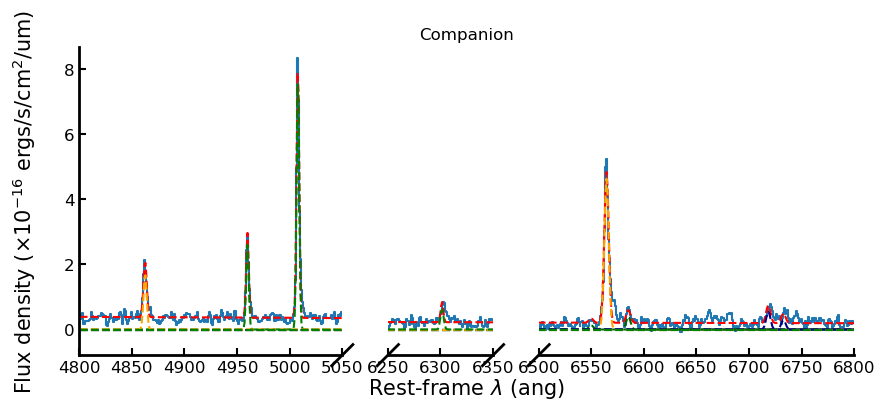

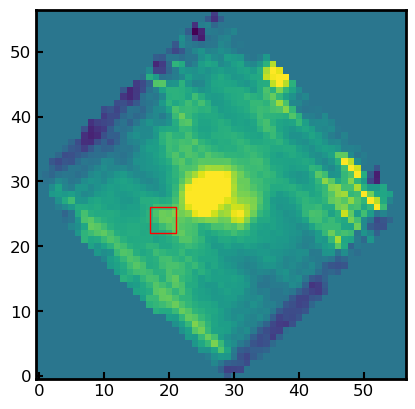

In [14]:
from brokenaxes import brokenaxes
Flux, Flux_er, mask = Cube.Regional_Spec(center=[19,24],rad=0.3,err_range=[2.6,2.76])

chains, fitted_model = emfit.fitting_Halpha_OIII(Cube.obs_wave, Flux, Flux_er, Cube.z)
sol = IFU.prop_calc(chains)

f = plt.figure(figsize=(10,4))
baxes = brokenaxes(xlims=((4800,5050),(6250,6350),(6500,6800)),  hspace=.01)
emplot.plotting_Halpha_OIII(Cube.obs_wave, Flux,baxes, sol,fitted_model)

baxes.set_title('Companion')
baxes.set_xlabel(r'Rest-frame $\lambda$ (ang)')
baxes.set_ylabel(r'Flux density ($\times 10^{-16}$ ergs/s/cm$^2$/um)')

f,ax =plt.subplots(1)
ax.imshow(Cube.Median_stack_white, origin='lower', vmax=Cube.Median_stack_white.max()*0.2)
mask_plot = mask[0,:,:].copy()
mask_plot[mask_plot==True] = 1
mask_plot[mask_plot==False]= 0
ax.contour(mask_plot, colors='red', linewidths=1.0, levels=(0.))

mask_comp = mask_plot.copy()

sol['Flux_Halpha'] = IFU.flux_calc_mcmc(sol,chains, 'Han', Cube.flux_norm)
sol['Flux_NII'] = IFU.flux_calc_mcmc(sol,chains, 'NII', Cube.flux_norm)
sol['Flux_OIII'] = IFU.flux_calc_mcmc(sol, chains, 'OIIIt', Cube.flux_norm)
sol['Flux_Hb'] = IFU.flux_calc_mcmc(sol,chains, 'Hbeta', Cube.flux_norm)
sol['Flux_OI'] = IFU.flux_calc_mcmc(sol,chains, 'OI', Cube.flux_norm)
sol['Flux_SIIr'] = IFU.flux_calc_mcmc(sol,chains, 'SIIr', Cube.flux_norm)
sol['Flux_SIIb'] = IFU.flux_calc_mcmc(sol,chains, 'SIIb', Cube.flux_norm)
print(sol)
print('Flux Halpha ', sol['Flux_Halpha'])
print('Flux NII ', sol['Flux_NII'])
print('Flux OIII ', sol['Flux_OIII'])
print('Flux hbeta', sol['Flux_Hb'])
print('Flux OI', sol['Flux_OI'])
print('Flux SIIr', sol['Flux_SIIr'])
print('Flux SIIb', sol['Flux_SIIb'])

plt.show()